# Workflow Overview

This notebook aims at detecting and segmenting bottle objects in images. Here's a breakdown of the workflow:

## 1. **Preparation**
   - **Environment Setup**: Import necessary libraries and set up configuration parameters.
   - **Model Loading**: Load the pretrained Faster R-CNN model for object detection and the U-Net model for image segmentation.

## 2. **Object Detection with Faster R-CNN**
   - **Image Loading**: Retrieve and preprocess the images from the `./input_images` directory.
   - **Bounding Box Prediction**: Using the Faster R-CNN, detect potential bottle objects in the images, and draw bounding boxes around these objects.


## 3. **Image Segmentation with U-Net**
   - **Preprocessing**: Enlarge the predicted bounding boxes to ensure it contains the whole object 
   - **Cropping**: Based on the bounding boxes predicted by Faster R-CNN, crop the images to focus on the bottle objects.
   - **Segmentation Prediction**: Pass the cropped images through the U-Net model to obtain segmentation masks for the bottle objects.
   
## 4. **Visualization**
   - **Display Images**: Display the images in a three-column format:
     - *First Column*: Original images with bounding boxes.
     - *Second Column*: Cropped images based on bounding boxes.
     - *Third Column*: Predicted segmentation masks for the cropped images.


In [4]:
import os
import random
import sys
import time
import numpy as np
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
from keras import backend as K
from keras.models import load_model, Model

sys.path.append('./Faster_R_CNN_for_detection')
from faster_rcnn_utils import *

### Set up configuration

In [6]:
# Path to the config file 
config_output_filename = os.path.join('./Faster_R_CNN_for_detection/weights_and_config/model_vgg_config.pickle')

# Load the config file
with open(config_output_filename, 'rb') as f_in:
	C = pickle.load(f_in)

# No augmentation while predicting
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

#### Define functions to format the images based on configuration

In [7]:
def format_img_size(img, C):
	""" formats the image size based on config """
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
		
	if width <= height:
		ratio = img_min_side/width
		new_height = int(ratio * height)
		new_width = int(img_min_side)
	else:
		ratio = img_min_side/height
		new_width = int(ratio * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	return img, ratio	

def format_img_channels(img, C):
	""" formats the image channels based on config """
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img

def format_img(img, C):
	""" formats an image for model prediction based on config """
	img, ratio = format_img_size(img, C)
	img = format_img_channels(img, C)
	return img, ratio

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):

	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))

	return (real_x1, real_y1, real_x2 ,real_y2)

### Build the Faster R-CNN model and load the weights

In [8]:
num_features = 512

input_shape_img = (None, None, 3)
input_shape_features = (None, None, num_features)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = nn_base(img_input, trainable=False)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(feature_map_input, roi_input, C.num_rois, nb_classes=len(C.class_mapping))

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

In [5]:
# Load the weights obtained from training
print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights('./Faster_R_CNN_for_detection/weights_and_config/model_frcnn_vgg.hdf5', by_name=True)
model_classifier.load_weights('./Faster_R_CNN_for_detection/weights_and_config/model_frcnn_vgg.hdf5', by_name=True)

# Compile
model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

Loading weights from model_frcnn_vgg.hdf5


In [6]:
# Switch key value for class mapping
class_mapping = C.class_mapping
class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

{0: 'Bottle', 1: 'bg'}


## Load U-Net model

In [7]:
unet = load_model("./U-Net_for_segmentation/saved_models_and_history/unet.h5")

#### Define function to enlarge bboxes

In [8]:
def enlarge_bbox(img, x1, y1, x2, y2, scale=0.3):
    """
    enlarge the bounding box and crop the image based on the 
    coordinates of the bounding boxe 
    """
    # Calculate coordinates for cropping with scaling
    width = x2 - x1
    height = y2 - y1
    center_x, center_y = x1 + width // 2, y1 + height // 2

    new_width = int(width * (1 + scale*2))
    new_height = int(height * (1 + scale))

    new_x1 = max(0, center_x - new_width // 2)
    new_y1 = max(0, center_y - new_height // 2)
    new_x2 = min(img.shape[1], center_x + new_width // 2)
    new_y2 = min(img.shape[0], center_y + new_height // 2)

    return new_x1, new_y1, new_x2, new_y2

## Detection and Segmentation

In [9]:
# Path to the input image directory
img_names = os.listdir('./input_images')

1.png
1/1 [==============================] - 1s 1s/step


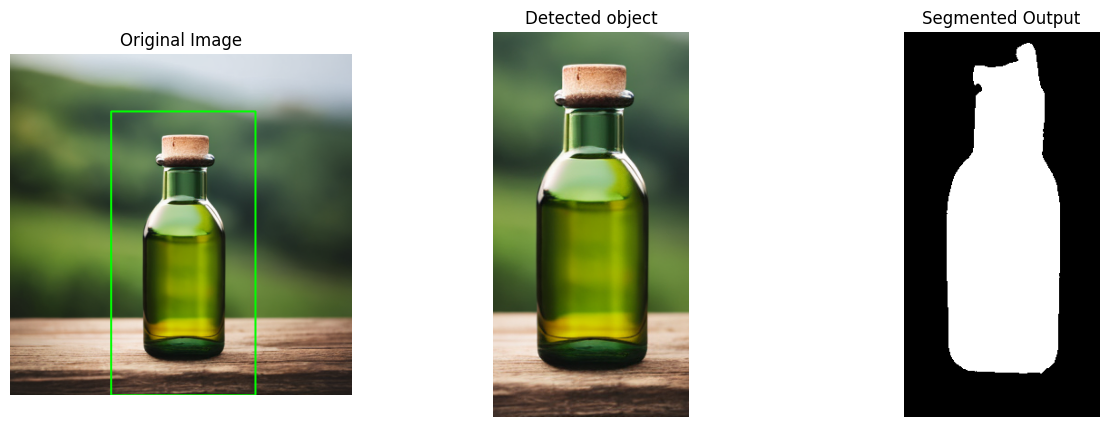

3.jpg
1/1 [==============================] - 0s 42ms/step


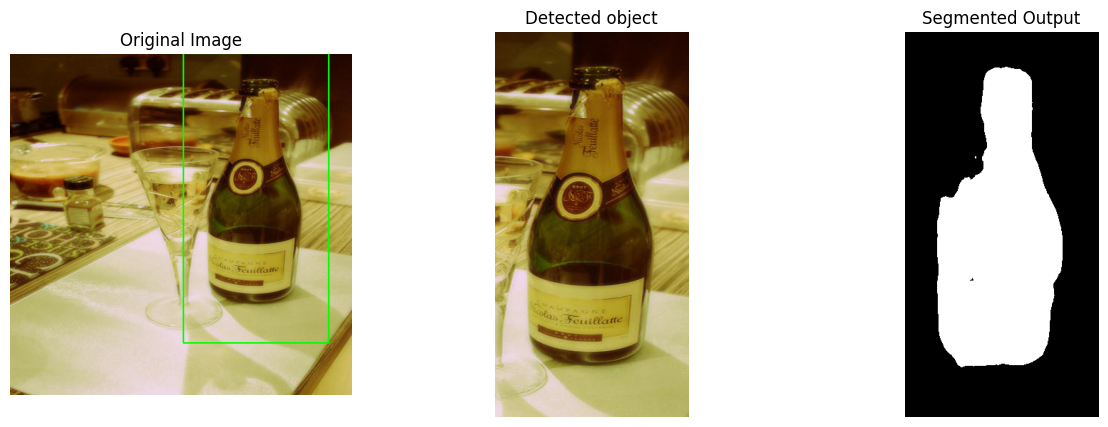

4.jpg
1/1 [==============================] - 0s 43ms/step


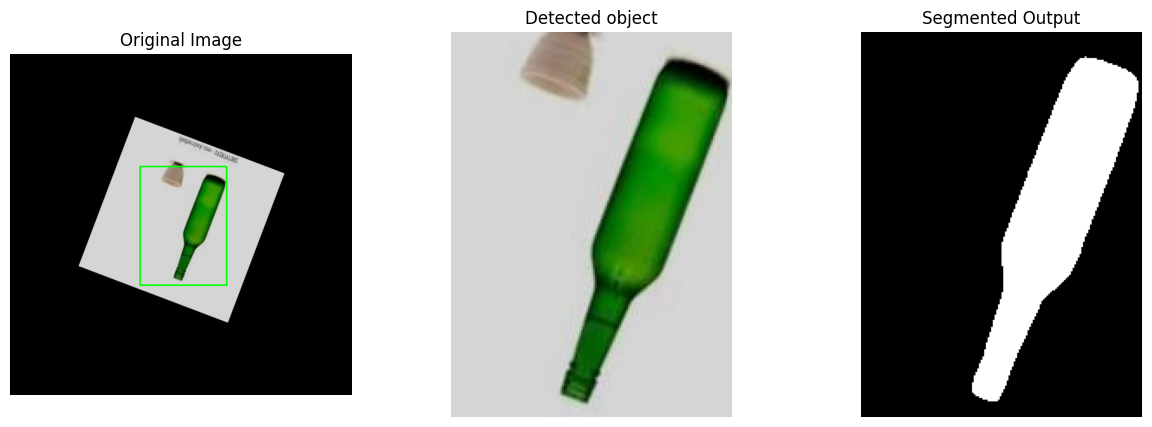

5.jpg
1/1 [==============================] - 0s 46ms/step


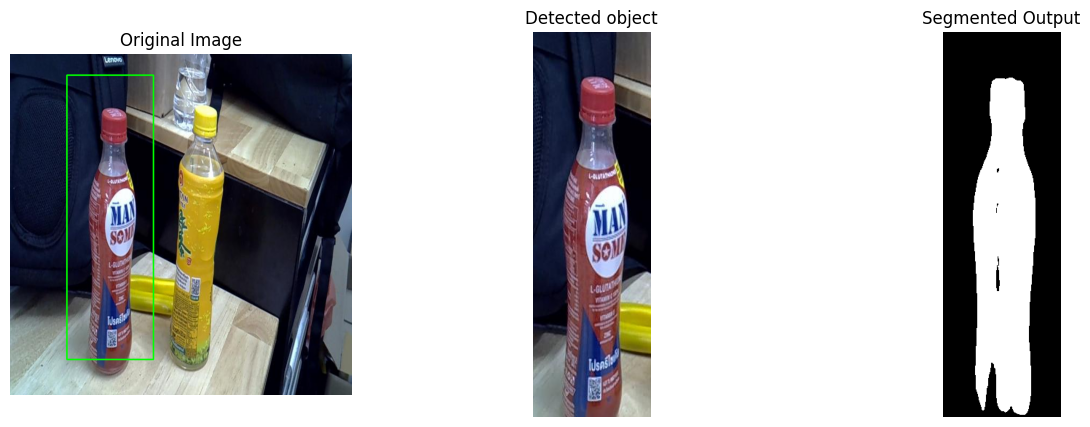

1/1 [==============================] - 0s 54ms/step


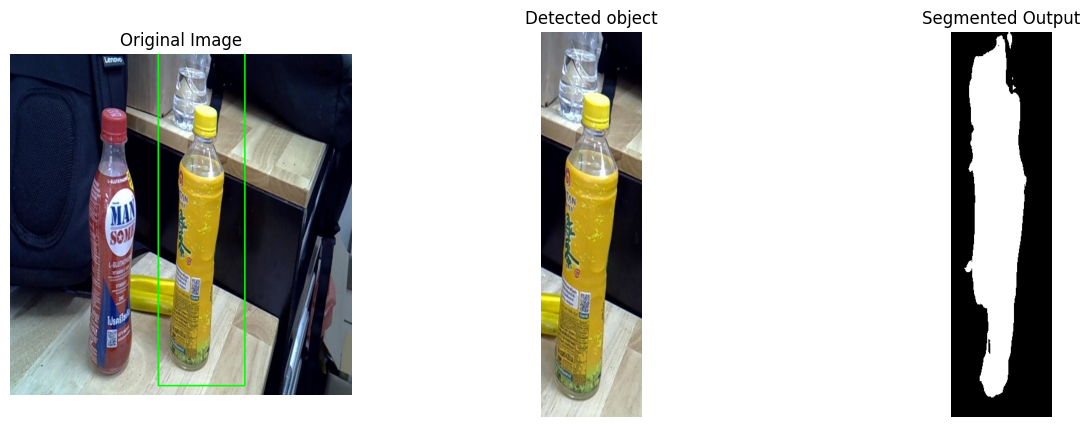

6.jpg
1/1 [==============================] - 0s 38ms/step


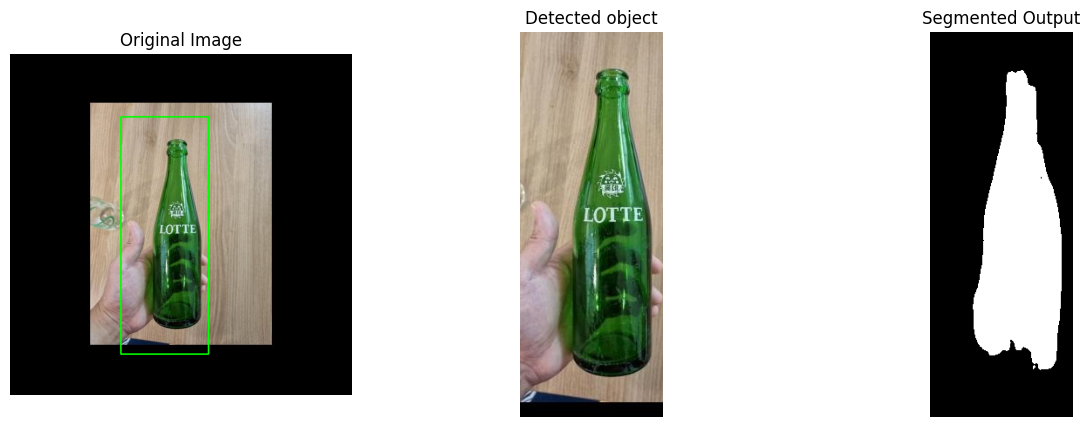

7.jpg
1/1 [==============================] - 0s 63ms/step


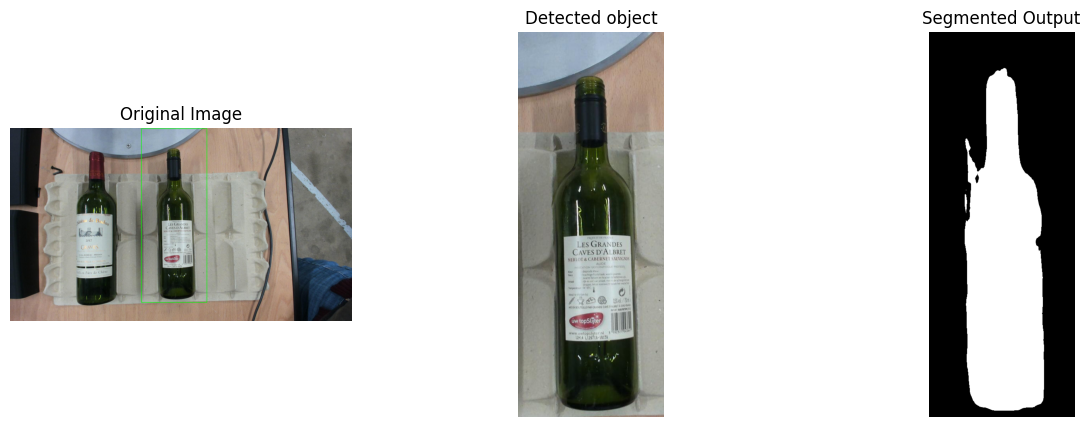

1/1 [==============================] - 0s 49ms/step


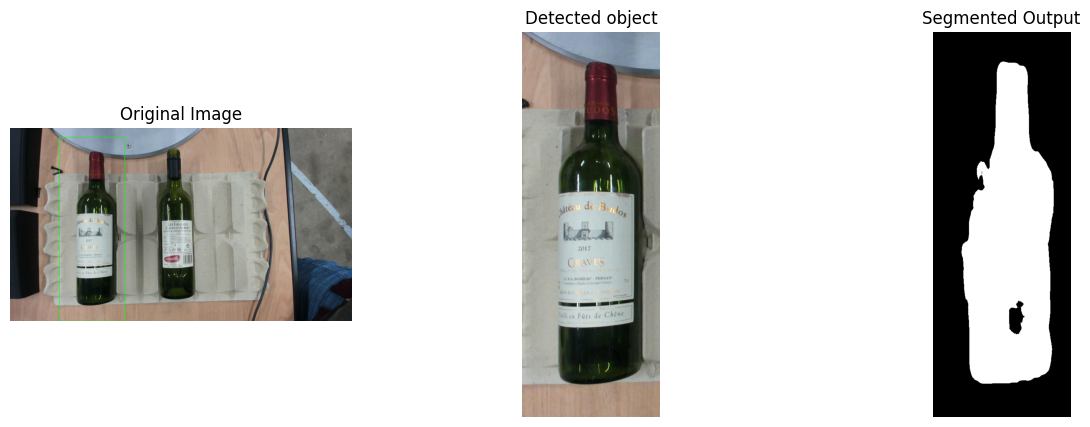

In [10]:
# The box will be ignored in case its classification score is less than bbox_threshold
bbox_threshold = 0.6

for idx, img_name in enumerate(img_names):
    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png')):
        continue
    print(img_name)
    st = time.time()
    filepath = os.path.join('./input_images', img_name)

    img = cv2.imread(filepath)

    X, ratio = format_img(img, C)
    
    X = np.transpose(X, (0, 2, 3, 1))

    # get output layer Y1, Y2 from the RPN and the feature maps F
    # Y1: y_rpn_cls
    # Y2: y_rpn_regr
    [Y1, Y2, F] = model_rpn.predict(X)

    # Get bboxes by applying NMS 
    # R.shape = (300, 4)
    R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.9)

    # Convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # Apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0]//C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0]//C.num_rois:
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        # Calculate bboxes coordinates on resized image
        for ii in range(P_cls.shape[1]):
            # Ignore 'bg' class
            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])
        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5, max_boxes=2)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]
            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)
            # Enlarge the bounding box (0.3 --> 30%)
            real_x1, real_y1, real_x2, real_y2 = enlarge_bbox(img, real_x1, real_y1, real_x2, real_y2, scale=0.3)

            # Crop the image using the bounding box
            cropped_img = img[real_y1:real_y2, real_x1:real_x2]

            # Pass the cropped image through U-Net for segmentation
            resized_cropped_img = cv2.resize(cropped_img, (128, 128))  
            pred = unet.predict(resized_cropped_img[np.newaxis, ...]/255.0)

            # Resize the predicted mask back to the size of cropped image
            pred_resized = cv2.resize(pred[0], (cropped_img.shape[1], cropped_img.shape[0]))

            # Convert prediction to binary mask 
            segmented_img = ((pred_resized > 0.5) * 255).astype(np.uint8)

            # Plotting
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))

            # Original image with bounding boxes
            img_with_bbox = img.copy()
            cv2.rectangle(img_with_bbox, (real_x1, real_y1), (real_x2, real_y2), (0, 255, 0), 2)
            axs[0].imshow(cv2.cvtColor(img_with_bbox, cv2.COLOR_BGR2RGB))
            axs[0].axis('off')
            axs[0].set_title('Original Image')
            
            # Cropped image
            axs[1].imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
            axs[1].axis('off')
            axs[1].set_title('Detected object')
            
            # Segmented image from U-Net
            axs[2].imshow(segmented_img.squeeze(), cmap='gray')
            axs[2].axis('off')
            axs[2].set_title('Segmented Output')

            plt.show()